<a href="https://colab.research.google.com/github/Joshua1030/APS360_Team17/blob/main/Primary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Loading and Splitting
Download data from kaggle and split them into train, validation, and test sets. Data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification

Since the dataset contains about 10,000 images over 6 categories, it will take very long to train our model. Our team decide to randomly choose 500 images for training, 100 images for validation, and 100 images for testing, from each category. 
Datasets can be downloaded by link: https://drive.google.com/drive/folders/1vMEit7Gcn2ZQd1DnRtb2J6Gn7FbUQP4T?usp=share_link

In [1]:
#import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#make sure to use the correct address
#small dataset for tune hyperparameters
#Weiman Sun_data_path
train_dir = "/content/gdrive/MyDrive/aps360Project_Small_Dataset/APS360_Data_Small_Train"
val_dir = "/content/gdrive/MyDrive/aps360Project_Small_Dataset/APS360_Data_Small_Val"
#test_dir = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Test"

In [ ]:
#data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
classes = ('freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges')

#resize all images to 224x224
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

trainset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
valset = torchvision.datasets.ImageFolder(val_dir, transform=transform)
#testset = torchvision.datasets.ImageFolder(test_dir, transform=transform)


#data loader
batch_size = 16

train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=16, num_workers=1, shuffle=True)
#test_loader = torch.utils.data.DataLoader(testset, batch_size=16, num_workers=1, shuffle=True)

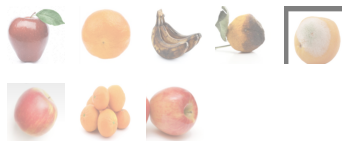

In [ ]:
#Visualize data
k = 0
for images, labels in val_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    #print(labels)
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

Primary Model

In [ ]:
#Convolutional Neural Network Architecture
class CNN(nn.Module):
    def __init__(self):
        self.name = "CNN"
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10*53*53, 32)
        self.fc2 = nn.Linear(32, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*53*53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
#overcome overfitting
class CNN_dropout(nn.Module):
    def __init__(self):
        self.name = "CNN_dropout"
        super(CNN_dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10*53*53, 32)
        self.fc2 = nn.Linear(32, 6)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*53*53)
        x = F.relu(self.fc1(x))
        # Apply dropout
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [3]:
#Convolutional Neural Network Architecture
class CNN_new(nn.Module):
    def __init__(self):
        self.name = "CNN_new"
        super(CNN_new, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #in_channels, out_chanels, kernel_size
        #self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(8*56*56, 56)
        self.fc2 = nn.Linear(56, 6)
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.max_pool2d(self.relu(self.conv1(x)), 2)
        x = F.max_pool2d(self.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        # Apply dropout
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
#add dropout on new CNN
class CNN_new_drop(nn.Module):
    def __init__(self):
        self.name = "CNN_new_drop"
        super(CNN_new_drop, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #in_channels, out_chanels, kernel_size
        #self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(8*56*56, 56)
        self.fc2 = nn.Linear(56, 6)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.max_pool2d(self.relu(self.conv1(x)), 2)
        x = F.max_pool2d(self.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        # Apply dropout
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
import matplotlib.pyplot as plt
def train(model, train, valid, batch_size=64, num_epochs=5, learning_rate=1e-5):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=1, shuffle=True)  
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, num_workers=1, shuffle=True)  

  # training
    for epoch in range(num_epochs):
        for imgs, labels in train_loader:
        
        
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
        train_losses.append(float(loss))

        for imgs, labels in valid_loader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = model(imgs)
            loss = criterion(out, labels)
        valid_losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train, batch_size))
        valid_acc.append(get_accuracy(model, valid, batch_size))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [5]:
def get_accuracy(model, data, batch_size):
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=1, shuffle=True)  

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        # to enable GPU Usage
        # begin
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        # end

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.795501; Train Acc 0.166667; Val Acc 0.166667
Epoch 2; Loss 1.757993; Train Acc 0.385000; Val Acc 0.350000
Epoch 3; Loss 1.748198; Train Acc 0.388333; Val Acc 0.375000
Epoch 4; Loss 1.717768; Train Acc 0.370000; Val Acc 0.375000
Epoch 5; Loss 1.651971; Train Acc 0.383333; Val Acc 0.375000


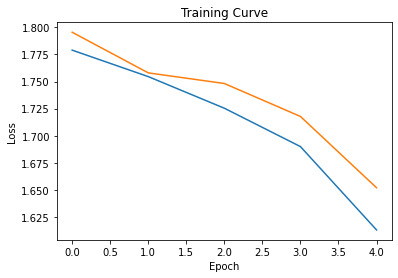

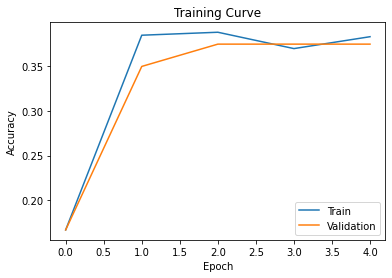

In [ ]:
#default one
fruit = CNN()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit, trainset, valset, batch_size=64, num_epochs=5, learning_rate=0.0001)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.793509; Train Acc 0.166667; Val Acc 0.166667
Epoch 2; Loss 1.781351; Train Acc 0.166667; Val Acc 0.166667
Epoch 3; Loss 1.798696; Train Acc 0.166667; Val Acc 0.166667
Epoch 4; Loss 1.554117; Train Acc 0.286667; Val Acc 0.275000
Epoch 5; Loss 1.602293; Train Acc 0.281667; Val Acc 0.300000


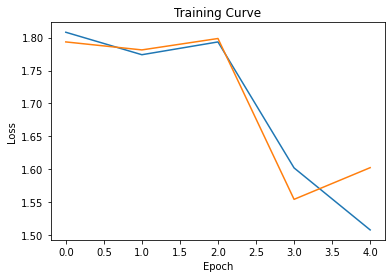

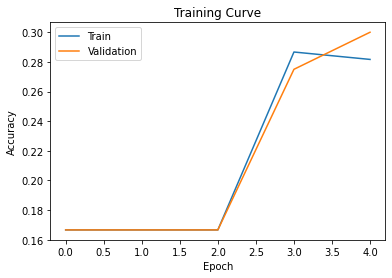

In [ ]:
#Version 1:
#batch_size = 16
#num_of_epoches = 5
#lr = 0.0001

fruit1 = CNN()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit1, trainset, valset, batch_size=16, num_epochs=5, learning_rate=0.0001)


CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.793509; Train Acc 0.166667; Val Acc 0.166667
Epoch 2; Loss 1.781358; Train Acc 0.166667; Val Acc 0.166667
Epoch 3; Loss 1.798690; Train Acc 0.166667; Val Acc 0.166667
Epoch 4; Loss 1.553927; Train Acc 0.285000; Val Acc 0.275000
Epoch 5; Loss 1.603690; Train Acc 0.281667; Val Acc 0.300000
Epoch 6; Loss 1.803815; Train Acc 0.335000; Val Acc 0.341667
Epoch 7; Loss 1.626050; Train Acc 0.353333; Val Acc 0.350000
Epoch 8; Loss 1.726850; Train Acc 0.375000; Val Acc 0.375000
Epoch 9; Loss 1.443345; Train Acc 0.438333; Val Acc 0.375000
Epoch 10; Loss 1.774028; Train Acc 0.391667; Val Acc 0.366667
Epoch 11; Loss 2.001411; Train Acc 0.458333; Val Acc 0.391667
Epoch 12; Loss 1.258234; Train Acc 0.476667; Val Acc 0.425000
Epoch 13; Loss 1.735698; Train Acc 0.480000; Val Acc 0.416667
Epoch 14; Loss 0.965414; Train Acc 0.531667; Val Acc 0.466667
Epoch 15; Loss 1.271906; Train Acc 0.583333; Val Acc 0.508333
Epoch 16; Loss 1.143337; Train Acc 0.58

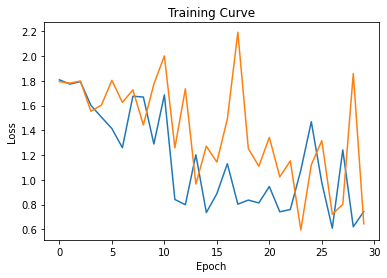

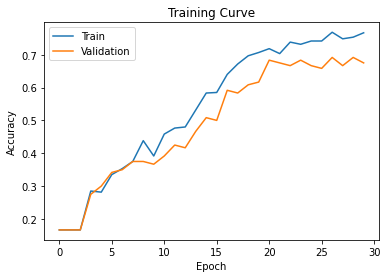

In [ ]:
#Version 2: increase the num of epochs
#batch_size = 16
#num_of_epoches = 30
#lr = 0.0001

fruit2 = CNN()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit2, trainset, valset, batch_size=16, num_epochs=30, learning_rate=0.0001)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.757722; Train Acc 0.310000; Val Acc 0.316667
Epoch 2; Loss 1.743574; Train Acc 0.315000; Val Acc 0.316667
Epoch 3; Loss 1.737466; Train Acc 0.340000; Val Acc 0.350000
Epoch 4; Loss 1.678283; Train Acc 0.363333; Val Acc 0.366667
Epoch 5; Loss 1.609612; Train Acc 0.531667; Val Acc 0.525000
Epoch 6; Loss 1.538336; Train Acc 0.518333; Val Acc 0.533333
Epoch 7; Loss 1.414402; Train Acc 0.490000; Val Acc 0.475000
Epoch 8; Loss 1.303773; Train Acc 0.573333; Val Acc 0.575000
Epoch 9; Loss 1.268345; Train Acc 0.608333; Val Acc 0.566667
Epoch 10; Loss 1.182994; Train Acc 0.601667; Val Acc 0.566667
Epoch 11; Loss 1.121020; Train Acc 0.625000; Val Acc 0.591667
Epoch 12; Loss 0.969574; Train Acc 0.638333; Val Acc 0.608333
Epoch 13; Loss 1.009438; Train Acc 0.645000; Val Acc 0.633333
Epoch 14; Loss 1.014855; Train Acc 0.668333; Val Acc 0.625000
Epoch 15; Loss 0.994434; Train Acc 0.663333; Val Acc 0.650000
Epoch 16; Loss 0.894773; Train Acc 0.68

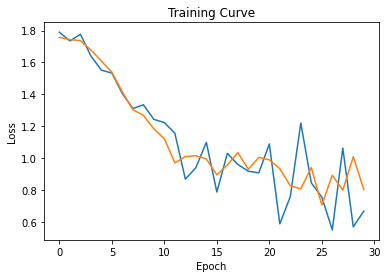

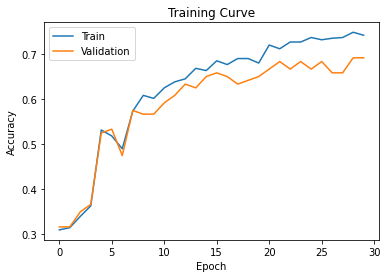

In [ ]:
#Version 3: change batch size from 16 to 64
#batch_size = 64
#num_of_epoches = 30
#lr = 0.0001

fruit3 = CNN()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit3, trainset, valset, batch_size=64, num_epochs=30, learning_rate=0.0001)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.704006; Train Acc 0.385000; Val Acc 0.383333
Epoch 2; Loss 1.243482; Train Acc 0.485000; Val Acc 0.475000
Epoch 3; Loss 1.269259; Train Acc 0.541667; Val Acc 0.450000
Epoch 4; Loss 1.030400; Train Acc 0.660000; Val Acc 0.608333
Epoch 5; Loss 0.813415; Train Acc 0.760000; Val Acc 0.708333
Epoch 6; Loss 0.950570; Train Acc 0.791667; Val Acc 0.716667
Epoch 7; Loss 0.763711; Train Acc 0.693333; Val Acc 0.700000
Epoch 8; Loss 0.864190; Train Acc 0.775000; Val Acc 0.666667
Epoch 9; Loss 0.743360; Train Acc 0.850000; Val Acc 0.816667
Epoch 10; Loss 0.536957; Train Acc 0.843333; Val Acc 0.766667
Epoch 11; Loss 0.585726; Train Acc 0.860000; Val Acc 0.733333
Epoch 12; Loss 0.520998; Train Acc 0.886667; Val Acc 0.783333
Epoch 13; Loss 0.490654; Train Acc 0.908333; Val Acc 0.775000
Epoch 14; Loss 0.620625; Train Acc 0.921667; Val Acc 0.791667
Epoch 15; Loss 0.491847; Train Acc 0.938333; Val Acc 0.816667
Epoch 16; Loss 0.660967; Train Acc 0.87

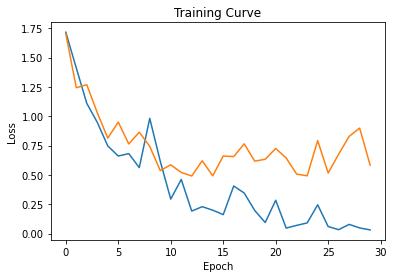

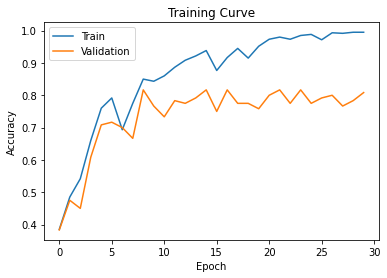

In [ ]:
#Version 4: change learning rate from 0.0001 to 0.001
#batch_size = 64
#num_of_epoches = 30
#lr = 0.001

fruit4 = CNN()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit4, trainset, valset, batch_size=64, num_epochs=30, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.745264; Train Acc 0.165000; Val Acc 0.175000
Epoch 2; Loss 1.446305; Train Acc 0.380000; Val Acc 0.300000
Epoch 3; Loss 1.351489; Train Acc 0.396667; Val Acc 0.333333
Epoch 4; Loss 1.358878; Train Acc 0.431667; Val Acc 0.433333
Epoch 5; Loss 1.321174; Train Acc 0.481667; Val Acc 0.391667
Epoch 6; Loss 1.265501; Train Acc 0.521667; Val Acc 0.458333
Epoch 7; Loss 1.312619; Train Acc 0.535000; Val Acc 0.433333
Epoch 8; Loss 1.167894; Train Acc 0.576667; Val Acc 0.508333
Epoch 9; Loss 1.172636; Train Acc 0.600000; Val Acc 0.541667
Epoch 10; Loss 1.097336; Train Acc 0.561667; Val Acc 0.458333
Epoch 11; Loss 1.120898; Train Acc 0.610000; Val Acc 0.566667
Epoch 12; Loss 1.041692; Train Acc 0.620000; Val Acc 0.550000
Epoch 13; Loss 0.906303; Train Acc 0.665000; Val Acc 0.566667
Epoch 14; Loss 1.304488; Train Acc 0.673333; Val Acc 0.600000
Epoch 15; Loss 0.975035; Train Acc 0.698333; Val Acc 0.608333
Epoch 16; Loss 0.842188; Train Acc 0.69

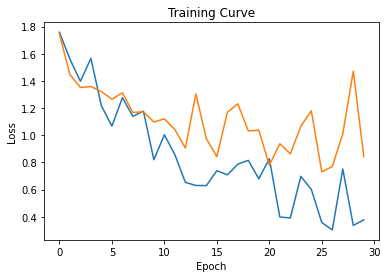

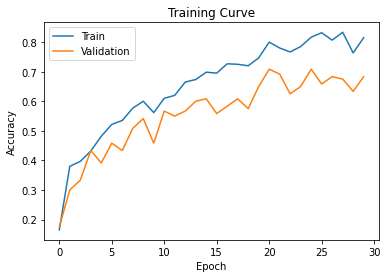

In [ ]:
#Version 5: addd dropout
#batch_size = 64
#num_of_epoches = 30
#lr = 0.001

fruit5 = CNN_dropout()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit5.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit5, trainset, valset, batch_size=64, num_epochs=30, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.761784; Train Acc 0.428333; Val Acc 0.408333
Epoch 2; Loss 1.729697; Train Acc 0.506667; Val Acc 0.500000
Epoch 3; Loss 1.688983; Train Acc 0.448333; Val Acc 0.441667
Epoch 4; Loss 1.644121; Train Acc 0.446667; Val Acc 0.450000
Epoch 5; Loss 1.596494; Train Acc 0.461667; Val Acc 0.466667
Epoch 6; Loss 1.546441; Train Acc 0.463333; Val Acc 0.466667
Epoch 7; Loss 1.495165; Train Acc 0.465000; Val Acc 0.466667
Epoch 8; Loss 1.443308; Train Acc 0.471667; Val Acc 0.475000
Epoch 9; Loss 1.396547; Train Acc 0.498333; Val Acc 0.475000
Epoch 10; Loss 1.340870; Train Acc 0.520000; Val Acc 0.475000
Epoch 11; Loss 1.287632; Train Acc 0.536667; Val Acc 0.500000
Epoch 12; Loss 1.237571; Train Acc 0.570000; Val Acc 0.516667
Epoch 13; Loss 1.187717; Train Acc 0.610000; Val Acc 0.575000
Epoch 14; Loss 1.144814; Train Acc 0.621667; Val Acc 0.583333
Epoch 15; Loss 1.096966; Train Acc 0.643333; Val Acc 0.591667
Epoch 16; Loss 1.058323; Train Acc 0.66

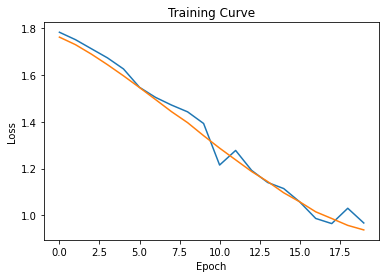

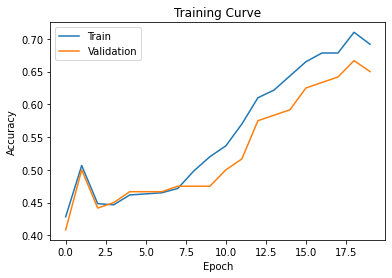

In [ ]:
#Version 6: change model, kernal size
#batch_size = 124
#num_of_epoches = 20
#lr = 0.0001

fruit6 = CNN_new()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit6.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit6, trainset, valset, batch_size=124, num_epochs=20, learning_rate=0.0001)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.731232; Train Acc 0.383333; Val Acc 0.375000
Epoch 2; Loss 1.692572; Train Acc 0.375000; Val Acc 0.333333
Epoch 3; Loss 1.586462; Train Acc 0.491667; Val Acc 0.466667
Epoch 4; Loss 1.518474; Train Acc 0.511667; Val Acc 0.466667
Epoch 5; Loss 1.458783; Train Acc 0.570000; Val Acc 0.533333
Epoch 6; Loss 1.413516; Train Acc 0.573333; Val Acc 0.500000
Epoch 7; Loss 1.354960; Train Acc 0.591667; Val Acc 0.558333
Epoch 8; Loss 1.303107; Train Acc 0.615000; Val Acc 0.633333
Epoch 9; Loss 1.198018; Train Acc 0.618333; Val Acc 0.550000
Epoch 10; Loss 1.155028; Train Acc 0.638333; Val Acc 0.575000
Epoch 11; Loss 1.111066; Train Acc 0.671667; Val Acc 0.666667
Epoch 12; Loss 0.936614; Train Acc 0.678333; Val Acc 0.658333
Epoch 13; Loss 0.957975; Train Acc 0.695000; Val Acc 0.608333
Epoch 14; Loss 1.007560; Train Acc 0.716667; Val Acc 0.658333
Epoch 15; Loss 0.937915; Train Acc 0.703333; Val Acc 0.675000
Epoch 16; Loss 0.932444; Train Acc 0.73

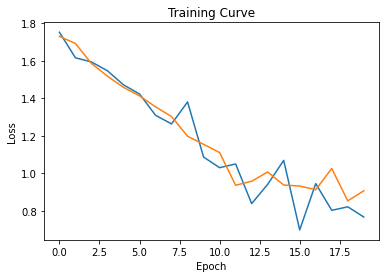

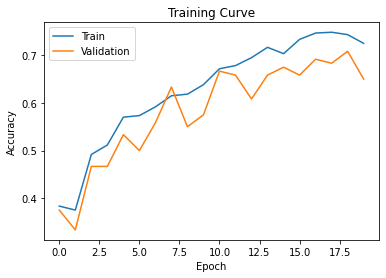

In [ ]:
#Version 7: change batch_size
#batch_size = 64
#num_of_epoches = 20
#lr = 0.0001

fruit7 = CNN_new()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit7.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit7, trainset, valset, batch_size=64, num_epochs=20, learning_rate=0.0001)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.554891; Train Acc 0.435000; Val Acc 0.500000
Epoch 2; Loss 1.197532; Train Acc 0.523333; Val Acc 0.550000
Epoch 3; Loss 1.162861; Train Acc 0.556667; Val Acc 0.525000
Epoch 4; Loss 0.841509; Train Acc 0.675000; Val Acc 0.625000
Epoch 5; Loss 0.886238; Train Acc 0.710000; Val Acc 0.650000
Epoch 6; Loss 0.944310; Train Acc 0.766667; Val Acc 0.633333
Epoch 7; Loss 0.946513; Train Acc 0.748333; Val Acc 0.716667
Epoch 8; Loss 0.896768; Train Acc 0.820000; Val Acc 0.683333
Epoch 9; Loss 0.744620; Train Acc 0.838333; Val Acc 0.733333
Epoch 10; Loss 0.609863; Train Acc 0.890000; Val Acc 0.766667
Epoch 11; Loss 0.626601; Train Acc 0.886667; Val Acc 0.750000
Epoch 12; Loss 0.468765; Train Acc 0.886667; Val Acc 0.733333
Epoch 13; Loss 0.651746; Train Acc 0.926667; Val Acc 0.783333
Epoch 14; Loss 0.772284; Train Acc 0.908333; Val Acc 0.750000
Epoch 15; Loss 0.662728; Train Acc 0.963333; Val Acc 0.808333
Epoch 16; Loss 0.642345; Train Acc 0.96

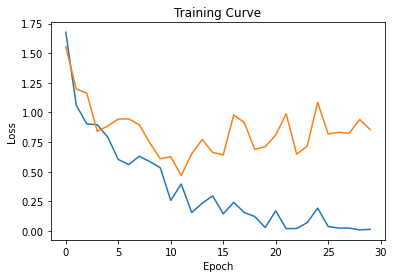

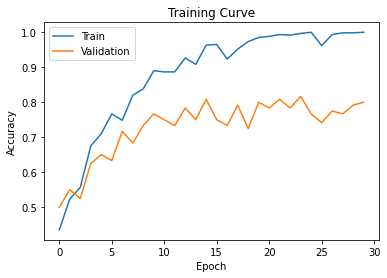

In [ ]:

#Version 8: change the eopchs and learning rate
#batch_size = 64
#num_of_epoches = 30
#lr = 0.001

fruit8 = CNN_new()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit8.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit8, trainset, valset, batch_size=64, num_epochs=30, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.703104; Train Acc 0.358333; Val Acc 0.316667
Epoch 2; Loss 1.426638; Train Acc 0.466667; Val Acc 0.441667
Epoch 3; Loss 1.223122; Train Acc 0.583333; Val Acc 0.525000
Epoch 4; Loss 1.125852; Train Acc 0.553333; Val Acc 0.533333
Epoch 5; Loss 0.955183; Train Acc 0.686667; Val Acc 0.608333
Epoch 6; Loss 1.123088; Train Acc 0.700000; Val Acc 0.650000
Epoch 7; Loss 0.906376; Train Acc 0.673333; Val Acc 0.608333
Epoch 8; Loss 0.927936; Train Acc 0.743333; Val Acc 0.716667
Epoch 9; Loss 0.855817; Train Acc 0.785000; Val Acc 0.725000
Epoch 10; Loss 0.788568; Train Acc 0.786667; Val Acc 0.691667
Epoch 11; Loss 0.652391; Train Acc 0.765000; Val Acc 0.708333
Epoch 12; Loss 0.668567; Train Acc 0.770000; Val Acc 0.725000
Epoch 13; Loss 0.723780; Train Acc 0.838333; Val Acc 0.700000
Epoch 14; Loss 0.741879; Train Acc 0.850000; Val Acc 0.733333
Epoch 15; Loss 0.756369; Train Acc 0.841667; Val Acc 0.741667
Epoch 16; Loss 0.682793; Train Acc 0.87

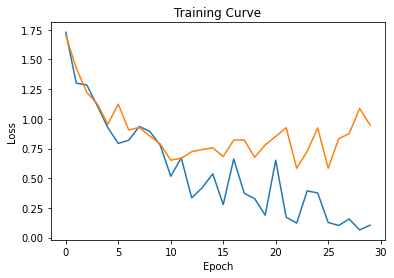

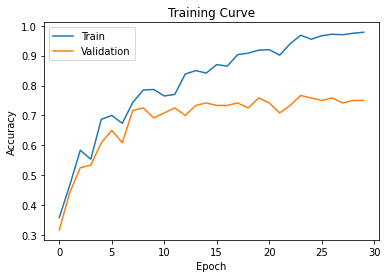

In [ ]:
#Version 9: change learning rate
#batch_size = 64
#num_of_epoches = 30
#lr = 0.0007

fruit9 = CNN_new()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit9.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit9, trainset, valset, batch_size=64, num_epochs=30, learning_rate=0.0007)

In [ ]:
#data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
classes = ('freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges')

#resize all images to 224x224
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.486], [0.229, 0.224, 0.225])
                                ])

trainset_aug = torchvision.datasets.ImageFolder(train_dir, transform=transform)
valset_aug = torchvision.datasets.ImageFolder(val_dir, transform=transform)
#testset = torchvision.datasets.ImageFolder(test_dir, transform=transform)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.736338; Train Acc 0.276667; Val Acc 0.241667
Epoch 2; Loss 1.690645; Train Acc 0.343333; Val Acc 0.308333
Epoch 3; Loss 1.533705; Train Acc 0.465000; Val Acc 0.391667
Epoch 4; Loss 1.289033; Train Acc 0.473333; Val Acc 0.516667
Epoch 5; Loss 0.967417; Train Acc 0.625000; Val Acc 0.675000
Epoch 6; Loss 1.033799; Train Acc 0.645000; Val Acc 0.608333
Epoch 7; Loss 0.815542; Train Acc 0.651667; Val Acc 0.641667
Epoch 8; Loss 0.694767; Train Acc 0.710000; Val Acc 0.666667
Epoch 9; Loss 0.779078; Train Acc 0.728333; Val Acc 0.658333
Epoch 10; Loss 0.698905; Train Acc 0.801667; Val Acc 0.708333
Epoch 11; Loss 0.561393; Train Acc 0.841667; Val Acc 0.716667
Epoch 12; Loss 0.451171; Train Acc 0.851667; Val Acc 0.766667
Epoch 13; Loss 0.571603; Train Acc 0.886667; Val Acc 0.733333
Epoch 14; Loss 0.627132; Train Acc 0.913333; Val Acc 0.791667
Epoch 15; Loss 0.660180; Train Acc 0.908333; Val Acc 0.791667
Epoch 16; Loss 0.493885; Train Acc 0.90

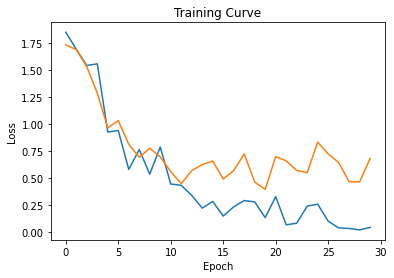

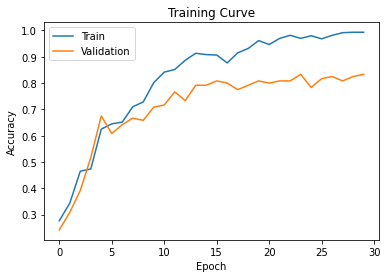

In [ ]:
#Version 10: data_augmentation based on version 9
#batch_size = 64
#num_of_epoches = 30
#lr = 0.001

fruit10 = CNN_new()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit10.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit10, trainset_aug, valset_aug, batch_size=64, num_epochs=30, learning_rate=0.001)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 1.457401; Train Acc 0.503333; Val Acc 0.475000
Epoch 2; Loss 1.125869; Train Acc 0.613333; Val Acc 0.550000
Epoch 3; Loss 0.796408; Train Acc 0.681667; Val Acc 0.691667
Epoch 4; Loss 0.789204; Train Acc 0.756667; Val Acc 0.700000
Epoch 5; Loss 0.716125; Train Acc 0.800000; Val Acc 0.691667
Epoch 6; Loss 1.125566; Train Acc 0.826667; Val Acc 0.733333
Epoch 7; Loss 0.747286; Train Acc 0.816667; Val Acc 0.733333
Epoch 8; Loss 0.972716; Train Acc 0.831667; Val Acc 0.716667
Epoch 9; Loss 0.860528; Train Acc 0.861667; Val Acc 0.791667
Epoch 10; Loss 0.621222; Train Acc 0.903333; Val Acc 0.766667
Epoch 11; Loss 0.747406; Train Acc 0.893333; Val Acc 0.758333
Epoch 12; Loss 0.627325; Train Acc 0.888333; Val Acc 0.741667
Epoch 13; Loss 0.775608; Train Acc 0.923333; Val Acc 0.741667
Epoch 14; Loss 0.933802; Train Acc 0.938333; Val Acc 0.783333
Epoch 15; Loss 0.623741; Train Acc 0.948333; Val Acc 0.775000
Epoch 16; Loss 0.697884; Train Acc 0.95

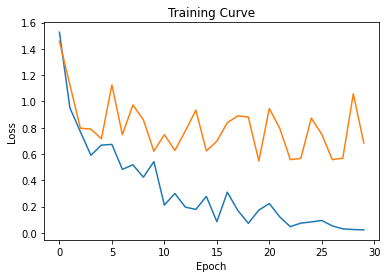

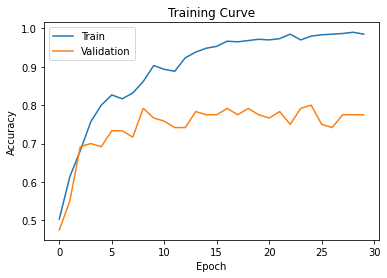

In [ ]:
#Version 11: add dropout on the cnn_new model
#batch_size = 64
#num_of_epoches = 30
#lr = 0.001

fruit11 = CNN_new_drop()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit11.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit11, trainset_aug, valset_aug, batch_size=64, num_epochs=30, learning_rate=0.001)

In [7]:
#make sure to use the correct address

train_dir_big = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Train"
val_dir_big = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Val"
test_dir_big = "/content/gdrive/MyDrive/APS360/Project_data_set/APS360_Data_Small_Test"

In [8]:
#data are downloded from https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
classes = ('freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges')

#resize all images to 224x224
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.486], [0.229, 0.224, 0.225])
                                ])

trainset_aug = torchvision.datasets.ImageFolder(train_dir_big, transform=transform)
valset_aug = torchvision.datasets.ImageFolder(val_dir_big, transform=transform)
#testset_aug = torchvision.datasets.ImageFolder(test_dir_big, transform=transform)

CUDA is available!  Training on GPU ...
Epoch 1; Loss 0.645287; Train Acc 0.735000; Val Acc 0.738333
Epoch 2; Loss 0.404768; Train Acc 0.845000; Val Acc 0.836667
Epoch 3; Loss 0.515451; Train Acc 0.851667; Val Acc 0.843333
Epoch 4; Loss 0.317836; Train Acc 0.902000; Val Acc 0.865000
Epoch 5; Loss 0.478127; Train Acc 0.837667; Val Acc 0.816667
Epoch 6; Loss 0.332707; Train Acc 0.933000; Val Acc 0.888333
Epoch 7; Loss 0.161735; Train Acc 0.930667; Val Acc 0.895000
Epoch 8; Loss 0.299112; Train Acc 0.945000; Val Acc 0.890000
Epoch 9; Loss 0.161852; Train Acc 0.955000; Val Acc 0.896667
Epoch 10; Loss 0.238771; Train Acc 0.929667; Val Acc 0.896667
Epoch 11; Loss 0.328021; Train Acc 0.949333; Val Acc 0.896667
Epoch 12; Loss 0.243722; Train Acc 0.977333; Val Acc 0.913333
Epoch 13; Loss 0.296542; Train Acc 0.944333; Val Acc 0.890000
Epoch 14; Loss 0.263832; Train Acc 0.960000; Val Acc 0.893333
Epoch 15; Loss 0.130829; Train Acc 0.989000; Val Acc 0.925000
Epoch 16; Loss 0.231124; Train Acc 0.98

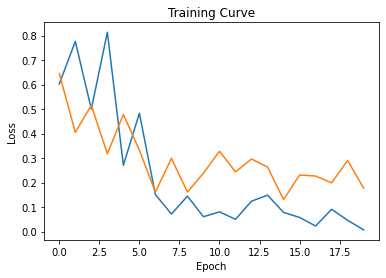

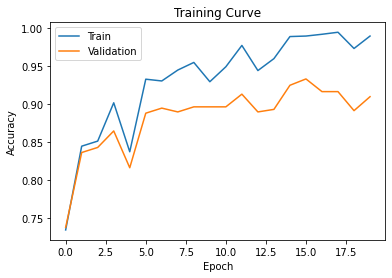

In [9]:
#Train on the big dataset
#batch_size = 124
#num_of_epoches = 20
#lr = 0.001

fruit_big1 = CNN_new()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  fruit_big1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(fruit_big1, trainset_aug, valset_aug, batch_size=124, num_epochs=20, learning_rate=0.001)